In [1]:
import omnipath
import pandas as pd
import corneto as cn
import decoupler as dc

cn.info()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CORNETO v0.9.1-alpha.0 (latest: v0.9.1-alpha.1)
Available backends:  CVXPY v1.3.1
Default backend (corneto.K): CVXPY
Available solvers for CVXPY: CBC, ECOS, ECOS_BB, OSQP, SCIPY, SCS
Graphviz available: v0.20.1.
https://github.com/saezlab/corneto


In [2]:
pkn = omnipath.interactions.OmniPath.get(genesymbols=True, signed=True).drop_duplicates(['source_genesymbol', 'target_genesymbol'])

In [3]:
pkn = dc.translate_net(pkn, columns=['source_genesymbol', 'target_genesymbol'])

In [4]:
# Assign mode of regulation
mor = []

for i in pkn.itertuples():

    if i.is_stimulation and i.is_inhibition:
        if i.consensus_stimulation:
            mor.append(1)
        else:
            mor.append(-1)
    elif i.is_stimulation:
        mor.append(1)
    elif i.is_inhibition:
        mor.append(-1)
    else:
        mor.append(1)

pkn['mor'] = mor

In [6]:
pkn_df = pkn[['source_genesymbol', 'mor', 'target_genesymbol']]

In [10]:
pkn_df['mor'].value_counts()

 1    14951
-1     5798
Name: mor, dtype: int64

In [7]:
# convert to graph
G = cn.Graph.from_sif_tuples([(r[1][0], r[1][1], r[1][2]) for r in pkn_df.iterrows()])

In [16]:
P, Gc = cn.methods.carnival.runVanillaCarnival({'Itgb1': 1}, {'Hnf4a': 1}, G, betaWeight=0.5)
P.solve(solver='CBC')
P.objectives[0].value

array([0.])

In [17]:
selected_vertices = P.symbols['species_activated_c0'].value + P.symbols['species_inhibited_c0'].value
selected_vertices

array([0., 0., 0., ..., 1., 1., 1.])

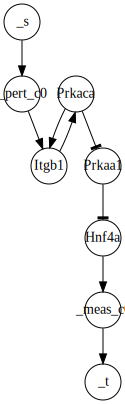

In [18]:
v = Gc.vertices
Gc.subgraph([v[i] for i, s in enumerate(selected_vertices) if s > 0]).plot()